In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
pt = pd.read_csv("data/PresentTopSoil.csv")
ps = pd.read_csv("data/PresentSubSoil.csv")

In [29]:
pt.columns

Index(['Location', 'LandUse', 'Latitude', 'Longitude', 'Stock', 'SOCT', 'pH',
       'TN', 'Clay', 'SBD', 'SOC%', 'SOCw', 'SOCi', 'CEC'],
      dtype='object')

In [36]:
import ee
import geemap

# Authenticate and initialize Google Earth Engine
ee.Authenticate()   # Follow on‑screen prompt in your browser
ee.Initialize(project="ee-arsenicbd")

In [6]:
import geopandas as gpd

shp_path = 'gis/StudyArea.shp'
gdf = gpd.read_file(shp_path)
study_area = geemap.gdf_to_ee(gdf)

In [7]:
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B5','B4']).rename('NDVI')  # for Landsat 8; adjust bands for 5/7
    return image.addBands(ndvi)

# Merge Landsat 5, 7, 8 collections with NDVI
landsat5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
              .filterBounds(study_area) \
              .map(lambda img: add_ndvi(img.resample('bicubic')))

landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
              .filterBounds(study_area) \
              .map(lambda img: add_ndvi(img.resample('bicubic')))

landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
              .filterBounds(study_area) \
              .map(lambda img: add_ndvi(img.resample('bicubic')))

landsat_all = landsat5.merge(landsat7).merge(landsat8)

In [8]:
def yearly_mean_ndvi(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    yearly_images = landsat_all.filterDate(start_date, end_date)
    mean_ndvi = yearly_images.select('NDVI').mean().clip(study_area)
    return mean_ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=study_area,
        scale=30,
        bestEffort=True
    ).get('NDVI')

years = list(range(1985, 2025))  # adjust timeframe if necessary

# Convert to ee.List and map
def to_feature(year):
    val = ee.Number(yearly_mean_ndvi(year))
    return ee.Feature(None, {'year': year, 'mean_ndvi': val})

features = ee.FeatureCollection(ee.List(years).map(lambda y: to_feature(y)))

In [12]:
def annual_mean(year):
    year = ee.Number(year)
    start = ee.Date.fromYMD(year,1,1)
    end = start.advance(1,'year')

    # Compute mean NDVI image for this year
    mean_image = (landsat
                  .filterDate(start, end)
                  .select('NDVI')
                  .mean()
                  .clip(roi))

    # Reduce to a single mean value over the ROI
    # reduceRegion returns a dictionary; specify a default value if 'NDVI' is missing
    mean_dict = mean_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True,
    )

    # Safely get the NDVI value; assign NaN if key doesn’t exist
    ndvi_value = ee.Dictionary(mean_dict).get('NDVI', ee.Number(float('nan')))

    return ee.Feature(None, {
        'year': year,
        'mean_ndvi': ndvi_value
    })


In [15]:
# NDVI functions for Level-2 Surface Reflectance datasets
def add_ndvi_l5(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l7(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l8(img):
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return img.addBands(ndvi)

# Load and map collections with the corrected NDVI functions
l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(roi).map(add_ndvi_l5)
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(roi).map(add_ndvi_l7)
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(roi).map(add_ndvi_l8)

landsat = l5.merge(l7).merge(l8)

# Annual mean function with a sentinel value for missing NDVI
def annual_mean(year):
    year = ee.Number(year)
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    mean_image = (landsat
                  .filterDate(start, end)
                  .select('NDVI')
                  .mean()
                  .clip(roi))
    mean_dict = mean_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True
    )
    ndvi_value = ee.Dictionary(mean_dict).get('NDVI', ee.Number(-9999))
    return ee.Feature(None, {'year': year, 'mean_ndvi': ndvi_value})

years = ee.List.sequence(1985, 2024)
annual_fc = ee.FeatureCollection(years.map(annual_mean))
annual_data = annual_fc.getInfo()['features']

df = pd.DataFrame({
    'year': [f['properties']['year'] for f in annual_data],
    'mean_ndvi': [f['properties']['mean_ndvi'] for f in annual_data]
})

# Filter out sentinel values (-9999)
df = df[df['mean_ndvi'] != -9999]

In [19]:
df.columns

Index(['year', 'mean_ndvi'], dtype='object')

<Axes: xlabel='year'>

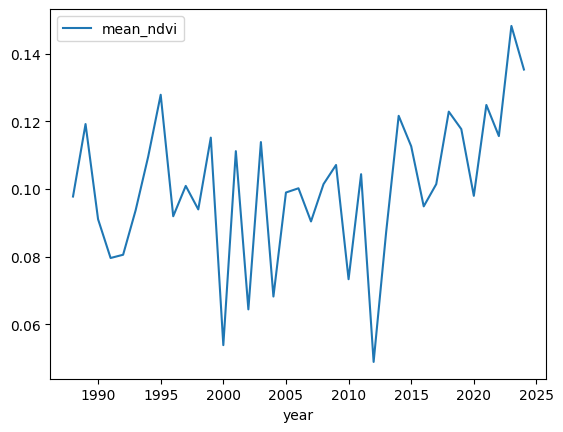

In [20]:
df.plot(x='year', y='mean_ndvi')

In [21]:
df.to_csv('geodata/ndvi_changes.csv')

In [25]:
shp_path = 'gis/StudyArea.shp'
gdf = gpd.read_file(shp_path)
roi_fc = geemap.gdf_to_ee(gdf)  
roi = roi_fc.geometry()

def add_ndvi_l5(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l7(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l8(img):
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return img.addBands(ndvi)

l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(roi).map(add_ndvi_l5)
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(roi).map(add_ndvi_l7)
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(roi).map(add_ndvi_l8)

landsat = l5.merge(l7).merge(l8)

def annual_mean(year):
    year = ee.Number(year)
    start = ee.Date.fromYMD(year, 1, 1)
    end   = start.advance(1, 'year')
    mean_image = (landsat
                  .filterDate(start, end)
                  .select('NDVI')
                  .mean()
                  .clip(roi))
    mean_dict = mean_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True,
        maxPixels=1e13
    )
    # use -9999 as a sentinel value for missing data
    ndvi_value = ee.Dictionary(mean_dict).get('NDVI', ee.Number(-9999))
    return ee.Feature(None, {'year': year, 'mean_ndvi': ndvi_value})

years = ee.List.sequence(1985, 2024)
annual_fc = ee.FeatureCollection(years.map(annual_mean))

annual_data = annual_fc.getInfo()['features']
df = pd.DataFrame({
    'year': [f['properties']['year'] for f in annual_data],
    'mean_ndvi': [f['properties']['mean_ndvi'] for f in annual_data]
})

df['mean_ndvi'] = df['mean_ndvi'].replace(-9999, np.nan)

# Biomass (t/ha/year) = 11.59 * NDVI^2 – 4.96 * NDVI + 0.76
df['biomass_t_ha_yr'] = 11.59 * df['mean_ndvi']**2 - 4.96 * df['mean_ndvi'] + 0.76
df

,year,mean_ndvi,biomass_t_ha_yr
0,1985,NaN,NaN
1,1986,NaN,NaN
2,1987,NaN,NaN
3,1988,0.097779,0.385825
4,1989,0.119175,0.333500
5,1990,0.091081,0.404387
6,1991,0.079627,0.438536
7,1992,0.080586,0.435559
8,1993,0.093730,0.396922
9,1994,0.109544,0.355740


In [26]:
df.to_csv("geodata/biomass_ndvi.csv")

In [27]:
shp_path = 'gis/StudyArea.shp'
gdf = gpd.read_file(shp_path)
roi_fc = geemap.gdf_to_ee(gdf)  # convert geopandas GeoDataFrame to ee.FeatureCollection
roi = roi_fc.geometry()

# Load ESA CCI AGB ImageCollection
agb_col = ee.ImageCollection("projects/sat-io/open-datasets/ESA/ESA_CCI_AGB")

# Map a function that sets a 'year' property from system:time_start
def set_year(img):
    year = ee.Date(img.get('system:time_start')).get('year')
    return img.set('year', year)

agb_col = agb_col.map(set_year)

# Get unique years in the collection and convert to Python list
years_in_dataset = agb_col.aggregate_array('year').distinct().getInfo()

# Define the full range of years you want (1985–2025)
full_years = list(range(1985, 2026))

# Compute mean biomass and total biomass for each year in the dataset;
# use None for years without data.
def get_biomass_for_year(y):
    if y in years_in_dataset:
        img = agb_col.filter(ee.Filter.eq('year', y)).first()
        # First band stores AGB (Mg/ha):contentReference[oaicite:1]{index=1}.
        agb_band = img.select(0)
        mean_dict = agb_band.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=100,      # dataset native resolution (~100 m)
            bestEffort=True,
            maxPixels=1e13
        )
        # Extract the mean value using the band name (band index 0)
        band_name = agb_band.bandNames().get(0).getInfo()
        mean_val = mean_dict.getInfo().get(band_name)
        # Compute total AGB (Mg) by multiplying mean by area (ha)
        area_ha = roi.area().getInfo() / 10000.0
        total_biomass = mean_val * area_ha if mean_val is not None else None
        return mean_val, total_biomass
    else:
        # No data for this year
        return None, None

# Build a list of dictionaries with year, mean AGB and total AGB
data = []
for year in full_years:
    mean_agb, total_agb = get_biomass_for_year(year)
    # Use NaN for missing data
    data.append({
        'year': year,
        'mean_agb_Mg_per_ha': mean_agb if mean_agb is not None else np.nan,
        'total_agb_Mg': total_agb if total_agb is not None else np.nan
    })

df = pd.DataFrame(data)
df

,year,mean_agb_Mg_per_ha,total_agb_Mg
0,1985,NaN,NaN
1,1986,NaN,NaN
2,1987,NaN,NaN
3,1988,NaN,NaN
4,1989,NaN,NaN
5,1990,NaN,NaN
6,1991,NaN,NaN
7,1992,NaN,NaN
8,1993,NaN,NaN
9,1994,NaN,NaN


In [28]:
df.to_csv("geodata/biomass_agb.csv")

In [31]:
import ee
import geopandas as gpd
import geemap
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt

shp_path = 'gis/Location.shp'
gdf = gpd.read_file(shp_path)

# Convert GeoDataFrame to EE FeatureCollection
locations_fc = geemap.gdf_to_ee(gdf)

# -----------------------------------------------------------------------------
# 3. Define functions to add NDVI for Landsat 5, 7 and 8 (Surface Reflectance)
# -----------------------------------------------------------------------------
def add_ndvi_l5(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l7(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

def add_ndvi_l8(img):
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return img.addBands(ndvi)

# Load and map each Landsat collection
l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').map(add_ndvi_l5)
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').map(add_ndvi_l7)
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').map(add_ndvi_l8)
# Merge collections
landsat = l5.merge(l7).merge(l8)

# -----------------------------------------------------------------------------
# 4. Define a function to compute NDVI and biomass for two years
# -----------------------------------------------------------------------------
def get_ndvi_biomass(feature):
    """Compute NDVI and biomass at a point for 1985 and 2025."""
    feature = ee.Feature(feature)
    geom = feature.geometry()
    
    def compute_for_year(year):
        start = ee.Date.fromYMD(year, 1, 1)
        end   = start.advance(1, 'year')
        # Mean NDVI image for this year
        ndvi_image = landsat.filterDate(start, end) \
                            .filterBounds(geom) \
                            .select('NDVI') \
                            .mean()
        # Extract mean NDVI within a 30 m buffer around the point
        ndvi_val = ndvi_image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = geom.buffer(30),  # buffer radius in metres
            scale = 30
        ).get('NDVI')
        # Compute biomass using the polynomial model (t ha⁻¹ yr⁻¹):contentReference[oaicite:0]{index=0}
        biomass = ee.Number(ndvi_val).pow(2).multiply(11.59) \
                       .add(ee.Number(ndvi_val).multiply(-4.96)) \
                       .add(0.76)
        return ndvi_val, biomass

    # Compute values for 1985 and 2025
    ndvi_1985, biomass_1985 = compute_for_year(1985)
    ndvi_2025, biomass_2025 = compute_for_year(2025)
    
    # Return feature with new properties
    return feature.set({
        'NDVI_1985': ndvi_1985,
        'Biomass_1985': biomass_1985,
        'NDVI_2025': ndvi_2025,
        'Biomass_2025': biomass_2025
    })

# Map the function over all locations
processed_fc = locations_fc.map(get_ndvi_biomass)

# -----------------------------------------------------------------------------
# 5. Extract results into a pandas DataFrame
# -----------------------------------------------------------------------------
results = processed_fc.getInfo()['features']

# Convert to tidy rows: one row per location and year
records = []
for feat in results:
    props = feat['properties']
    loc_name = props.get('Location') or props.get('name')  # adjust if your shapefile uses another field
    # 1985
    records.append({
        'Location': loc_name,
        'Year': 1985,
        'NDVI': props.get('NDVI_1985'),
        'Biomass_t_ha': props.get('Biomass_1985')
    })
    # 2025
    records.append({
        'Location': loc_name,
        'Year': 2025,
        'NDVI': props.get('NDVI_2025'),
        'Biomass_t_ha': props.get('Biomass_2025')
    })

ndvi_biomass_df = pd.DataFrame(records)

# -----------------------------------------------------------------------------
# 6. Load your ground dataset and merge with NDVI/biomass results
# -----------------------------------------------------------------------------
# Replace the path and reader as appropriate (CSV/Excel).  The dataset must
# have 'Location' and 'Year' columns to allow merging.
ground_df = pd.read_csv('data/PresentTopSoil.csv')

# Merge on Location and Year
combined_df = ground_df.merge(ndvi_biomass_df, on=['Location'])

# Optional: compute change between 1985 and 2025
# pivot by year then compute differences
pivot = combined_df.pivot(index='Location', columns='Year')
combined_df['NDVI_change'] = pivot['NDVI'][2025] - pivot['NDVI'][1985]
combined_df['Biomass_change'] = pivot['Biomass_t_ha'][2025] - pivot['Biomass_t_ha'][1985]

# -----------------------------------------------------------------------------
# 7. Statistical analysis: correlations and regression
# -----------------------------------------------------------------------------
# Correlations between NDVI and biomass
pearson_ndvi_biomass, p_val = pearsonr(combined_df['NDVI'], combined_df['Biomass_t_ha'])
spearman_ndvi_biomass, p_val_sp = spearmanr(combined_df['NDVI'], combined_df['Biomass_t_ha'])

print(f"Pearson NDVI–Biomass correlation: {pearson_ndvi_biomass:.3f} (p={p_val:.4f})")
print(f"Spearman NDVI–Biomass correlation: {spearman_ndvi_biomass:.3f} (p={p_val_sp:.4f})")

# Regression models
X = combined_df[['NDVI']].values
Y = combined_df['Biomass_t_ha'].values

# Linear regression
lin_model = LinearRegression().fit(X, Y)
lin_r2 = lin_model.score(X, Y)

# Polynomial (degree 2) regression
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                           LinearRegression())
poly_model.fit(X, Y)
poly_r2 = poly_model.score(X, Y)

print(f"Linear regression R^2: {lin_r2:.3f}")
print(f"Polynomial regression R^2 (degree 2): {poly_r2:.3f}")

# Cross-validation for polynomial model
cv_scores = cross_val_score(poly_model, X, Y,
                            cv=KFold(n_splits=min(5, len(Y)), shuffle=True, random_state=42),
                            scoring='r2')
print(f"Cross-validated R^2 scores: {cv_scores}")
print(f"Mean CV R^2: {np.mean(cv_scores):.3f}")

# -----------------------------------------------------------------------------
# 8. Plot NDVI vs Biomass with regression curves
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.scatter(combined_df['NDVI'], combined_df['Biomass_t_ha'], color='blue', label='Data')
ndvi_sorted = np.sort(combined_df['NDVI'].values)
plt.plot(ndvi_sorted, lin_model.predict(ndvi_sorted.reshape(-1,1)), '--', label='Linear fit')
plt.plot(ndvi_sorted, poly_model.predict(ndvi_sorted.reshape(-1,1)), label='Poly fit (deg=2)')
plt.xlabel('NDVI')
plt.ylabel('Biomass (t/ha)')
plt.title('NDVI vs Biomass with Regression Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


EEException: Error in map(ID=1):
Dictionary.get: Dictionary does not contain key: 'NDVI'.

In [37]:
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geemap
import ee

# Define the class codes for Hydrological and Vegetation areas (example codes, replace with your actual codes)
WATER_CLASS = 1
VEGETATION_CLASS = 2
FLOODED_CLASS = 9
FLOOD_CLASS = 4
URBAN_CLASS = 7

# Initialize Google Earth Engine
ee.Initialize()

# Read the shapefile for study area (roi)
shp_path = 'gis/StudyArea.shp'
gdf = gpd.read_file(shp_path)
roi_fc = geemap.gdf_to_ee(gdf)  
roi = roi_fc.geometry()

# NDVI function for Landsat 5
def add_ndvi_l5(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

# NDVI function for Landsat 7
def add_ndvi_l7(img):
    ndvi = img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return img.addBands(ndvi)

# NDVI function for Landsat 8
def add_ndvi_l8(img):
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return img.addBands(ndvi)

# NDWI function for Landsat 5
def add_ndwi_l5(img):
    ndwi = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return img.addBands(ndwi)

# NDWI function for Landsat 7
def add_ndwi_l7(img):
    ndwi = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return img.addBands(ndwi)

# NDWI function for Landsat 8
def add_ndwi_l8(img):
    ndwi = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return img.addBands(ndwi)

# BUI function for Landsat 5 (using Band 6)
def add_bui_l5(img):
    bui = img.select('SR_B6').multiply(0.1).rename('BUI')  # Scaling factor for brightness temperature
    return img.addBands(bui)

# BUI function for Landsat 7 (using Band 6)
def add_bui_l7(img):
    bui = img.select('SR_B6').multiply(0.1).rename('BUI')  # Scaling factor for brightness temperature
    return img.addBands(bui)

# BUI function for Landsat 8 (using Band 10)
def add_bui_l8(img):
    bui = img.select('SR_B10').multiply(0.1).rename('BUI')  # Scaling factor for brightness temperature
    return img.addBands(bui)

# Define the Landsat ImageCollections and calculate NDVI, NDWI, and BUI for each year
l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(roi).map(add_ndvi_l5).map(add_ndwi_l5).map(add_bui_l5)
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(roi).map(add_ndvi_l7).map(add_ndwi_l7).map(add_bui_l7)
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(roi).map(add_ndvi_l8).map(add_ndwi_l8).map(add_bui_l8)

# Merge all Landsat collections
landsat = l5.merge(l7).merge(l8)

# Function to calculate annual mean NDVI, NDWI, and BUI
def annual_mean(year):
    year = ee.Number(year)
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    mean_ndvi_image = (landsat
                  .filterDate(start, end)
                  .select('NDVI')
                  .mean()
                  .clip(roi))
    
    mean_ndwi_image = (landsat
                  .filterDate(start, end)
                  .select('NDWI')
                  .mean()
                  .clip(roi))
    
    mean_bui_image = (landsat
                  .filterDate(start, end)
                  .select('BUI')
                  .mean()
                  .clip(roi))
    
    # Reduce the image to a region (roi) to get mean values
    mean_ndvi_dict = mean_ndvi_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True,
        maxPixels=1e13
    )
    
    mean_ndwi_dict = mean_ndwi_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True,
        maxPixels=1e13
    )
    
    mean_bui_dict = mean_bui_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,
        bestEffort=True,
        maxPixels=1e13
    )
    
    # Extract the NDVI, NDWI, and BUI values
    ndvi_value = ee.Dictionary(mean_ndvi_dict).get('NDVI', ee.Number(-9999))
    ndwi_value = ee.Dictionary(mean_ndwi_dict).get('NDWI', ee.Number(-9999))
    bui_value = ee.Dictionary(mean_bui_dict).get('BUI', ee.Number(-9999))
    
    return ee.Feature(None, {
        'year': year, 
        'mean_ndvi': ndvi_value,
        'mean_ndwi': ndwi_value,
        'mean_bui': bui_value
    })

# Generate a list of years from 1985 to 2024
years = ee.List.sequence(1985, 2024)

# Calculate annual mean NDVI, NDWI, and BUI for each year
annual_fc = ee.FeatureCollection(years.map(annual_mean))

# Convert the feature collection to pandas DataFrame
annual_data = annual_fc.getInfo()['features']
df = pd.DataFrame({
    'year': [f['properties']['year'] for f in annual_data],
    'mean_ndvi': [f['properties']['mean_ndvi'] for f in annual_data],
    'mean_ndwi': [f['properties']['mean_ndwi'] for f in annual_data],
    'mean_bui': [f['properties']['mean_bui'] for f in annual_data]
})

# Replace sentinel values (-9999) with NaN
df['mean_ndvi'] = df['mean_ndvi'].replace(-9999, np.nan)
df['mean_ndwi'] = df['mean_ndwi'].replace(-9999, np.nan)
df['mean_bui'] = df['mean_bui'].replace(-9999, np.nan)

# Biomass (t/ha/year) = 11.59 * NDVI^2 – 4.96 * NDVI + 0.76
df['biomass_t_ha_yr'] = 11.59 * df['mean_ndvi']**2 - 4.96 * df['mean_ndvi'] + 0.76

df

EEException: Caller does not have required permission to use project 517222506229. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=517222506229 and then retry. Propagation of the new permission may take a few minutes.